# **Drainage Data Exploratory Analysis**

Author: Bridget Bittmann

Date Created: 01/21/2022

Date Modified: 01/21/2022

In [1]:
#Import necessary packages

import pandas as pd #to work with data arrays
import numpy as np #to work with arrays and statistics
import matplotlib.pyplot as plt #create graphs 
from matplotlib.dates import DateFormatter #to help with timeseries
import glob #to batch import csv files
from sklearn import metrics #to find r2 values from regression
!pip install pymannkendall
import pymannkendall as mk #used to perform mann-kendall stationarity test
from sklearn.cluster import KMeans #to cluster using kmeans

In [3]:
#Navigate to your directory

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#Navigate to workspace

%cd /content/drive/MyDrive/spatial_colab/
%ls

/content/drive/MyDrive/spatial_colab
1986.tif  1988.tif  1990.tif  1992.tif  datasets/
1987.tif  1989.tif  1991.tif  1993.tif  pod_pou_lulcc/


In [5]:
### IMPORT ALL NEW CSV FILES INTO ONE DATAFRAME ###

all_files = [] #creates a list space for all the dataframes

csv = glob.glob('datasets/diversion_timeseries/fulltime_individual_canals/*.csv') #name for all the csv files
for f in csv: 
  df = pd.read_csv(f, parse_dates=['DataDate'], index_col=['DataDate'])
  all_files.append(df) #appends dataframes to one file list

In [7]:
## DATA QUALITY CONTROL PRIOR TO ANALYSIS ##

## Select only the diversions known to serve irrigation districts
#  Will remove reservoir, natural flow, and return flow data

drain_list = [] #create a list to store the diversion data frame in

for i in range(len(all_files)):
  sel_data = all_files[i]
  data_type = sel_data['DiversionTypeDescription'][1]
  if data_type == ('Drain'):
    drain_list.append(sel_data)
  else:
    None

## Select diversions with data from 1987-2021 for study
## All else is discarded

fullextent_list = []

for i in range(len(drain_list)):
  sel_data = drain_list[i]
  oldest_year = sel_data.index.year[0]
  if oldest_year <= 1987:
    fullextent_list.append(sel_data)
  else:
    None

## Crop each time series with full extent range to desired time series

croppped_data = []

for i in fullextent_list:
  sel_data = i
  if sel_data.index.year[-1]>=1987:
    crop = sel_data.truncate(before='1987-01-01')
    croppped_data.append(crop)
  else:
    None

## Find the names of all the canals in the dataframe list

names = []

for i in croppped_data:
  canal = i['DiversionName']
  names.append(canal[0])

## Fill in any missing winter values with 0 starting at 1987-01-01

dt_series = pd.date_range(start='1987-01-01', end='1987-01-31', freq = 'D' )
dt_df = pd.DataFrame(dt_series, index=dt_series)

drains = []

for i in range(len(croppped_data)):
  canal = croppped_data[i] #selects the specific diversion dataframe
  canal = pd.concat([dt_df, canal]) #adds the pandas series of dates to dataframe
  canal = canal.drop(labels=0, axis=1) #dropes the series column
  canal = canal.loc[~canal.index.duplicated(),:] #removes any duplicate index values
  canal = canal.asfreq('d') #fill each daily value
  canal['CFS'] = canal['CFS'].fillna(value=0) #fills CFS Nan values with 0, assumed during winter months or no data
  canal['DiversionName'] = canal['DiversionName'].fillna(names[i]) #fills Nan diversion name values
  drains.append(canal)

7


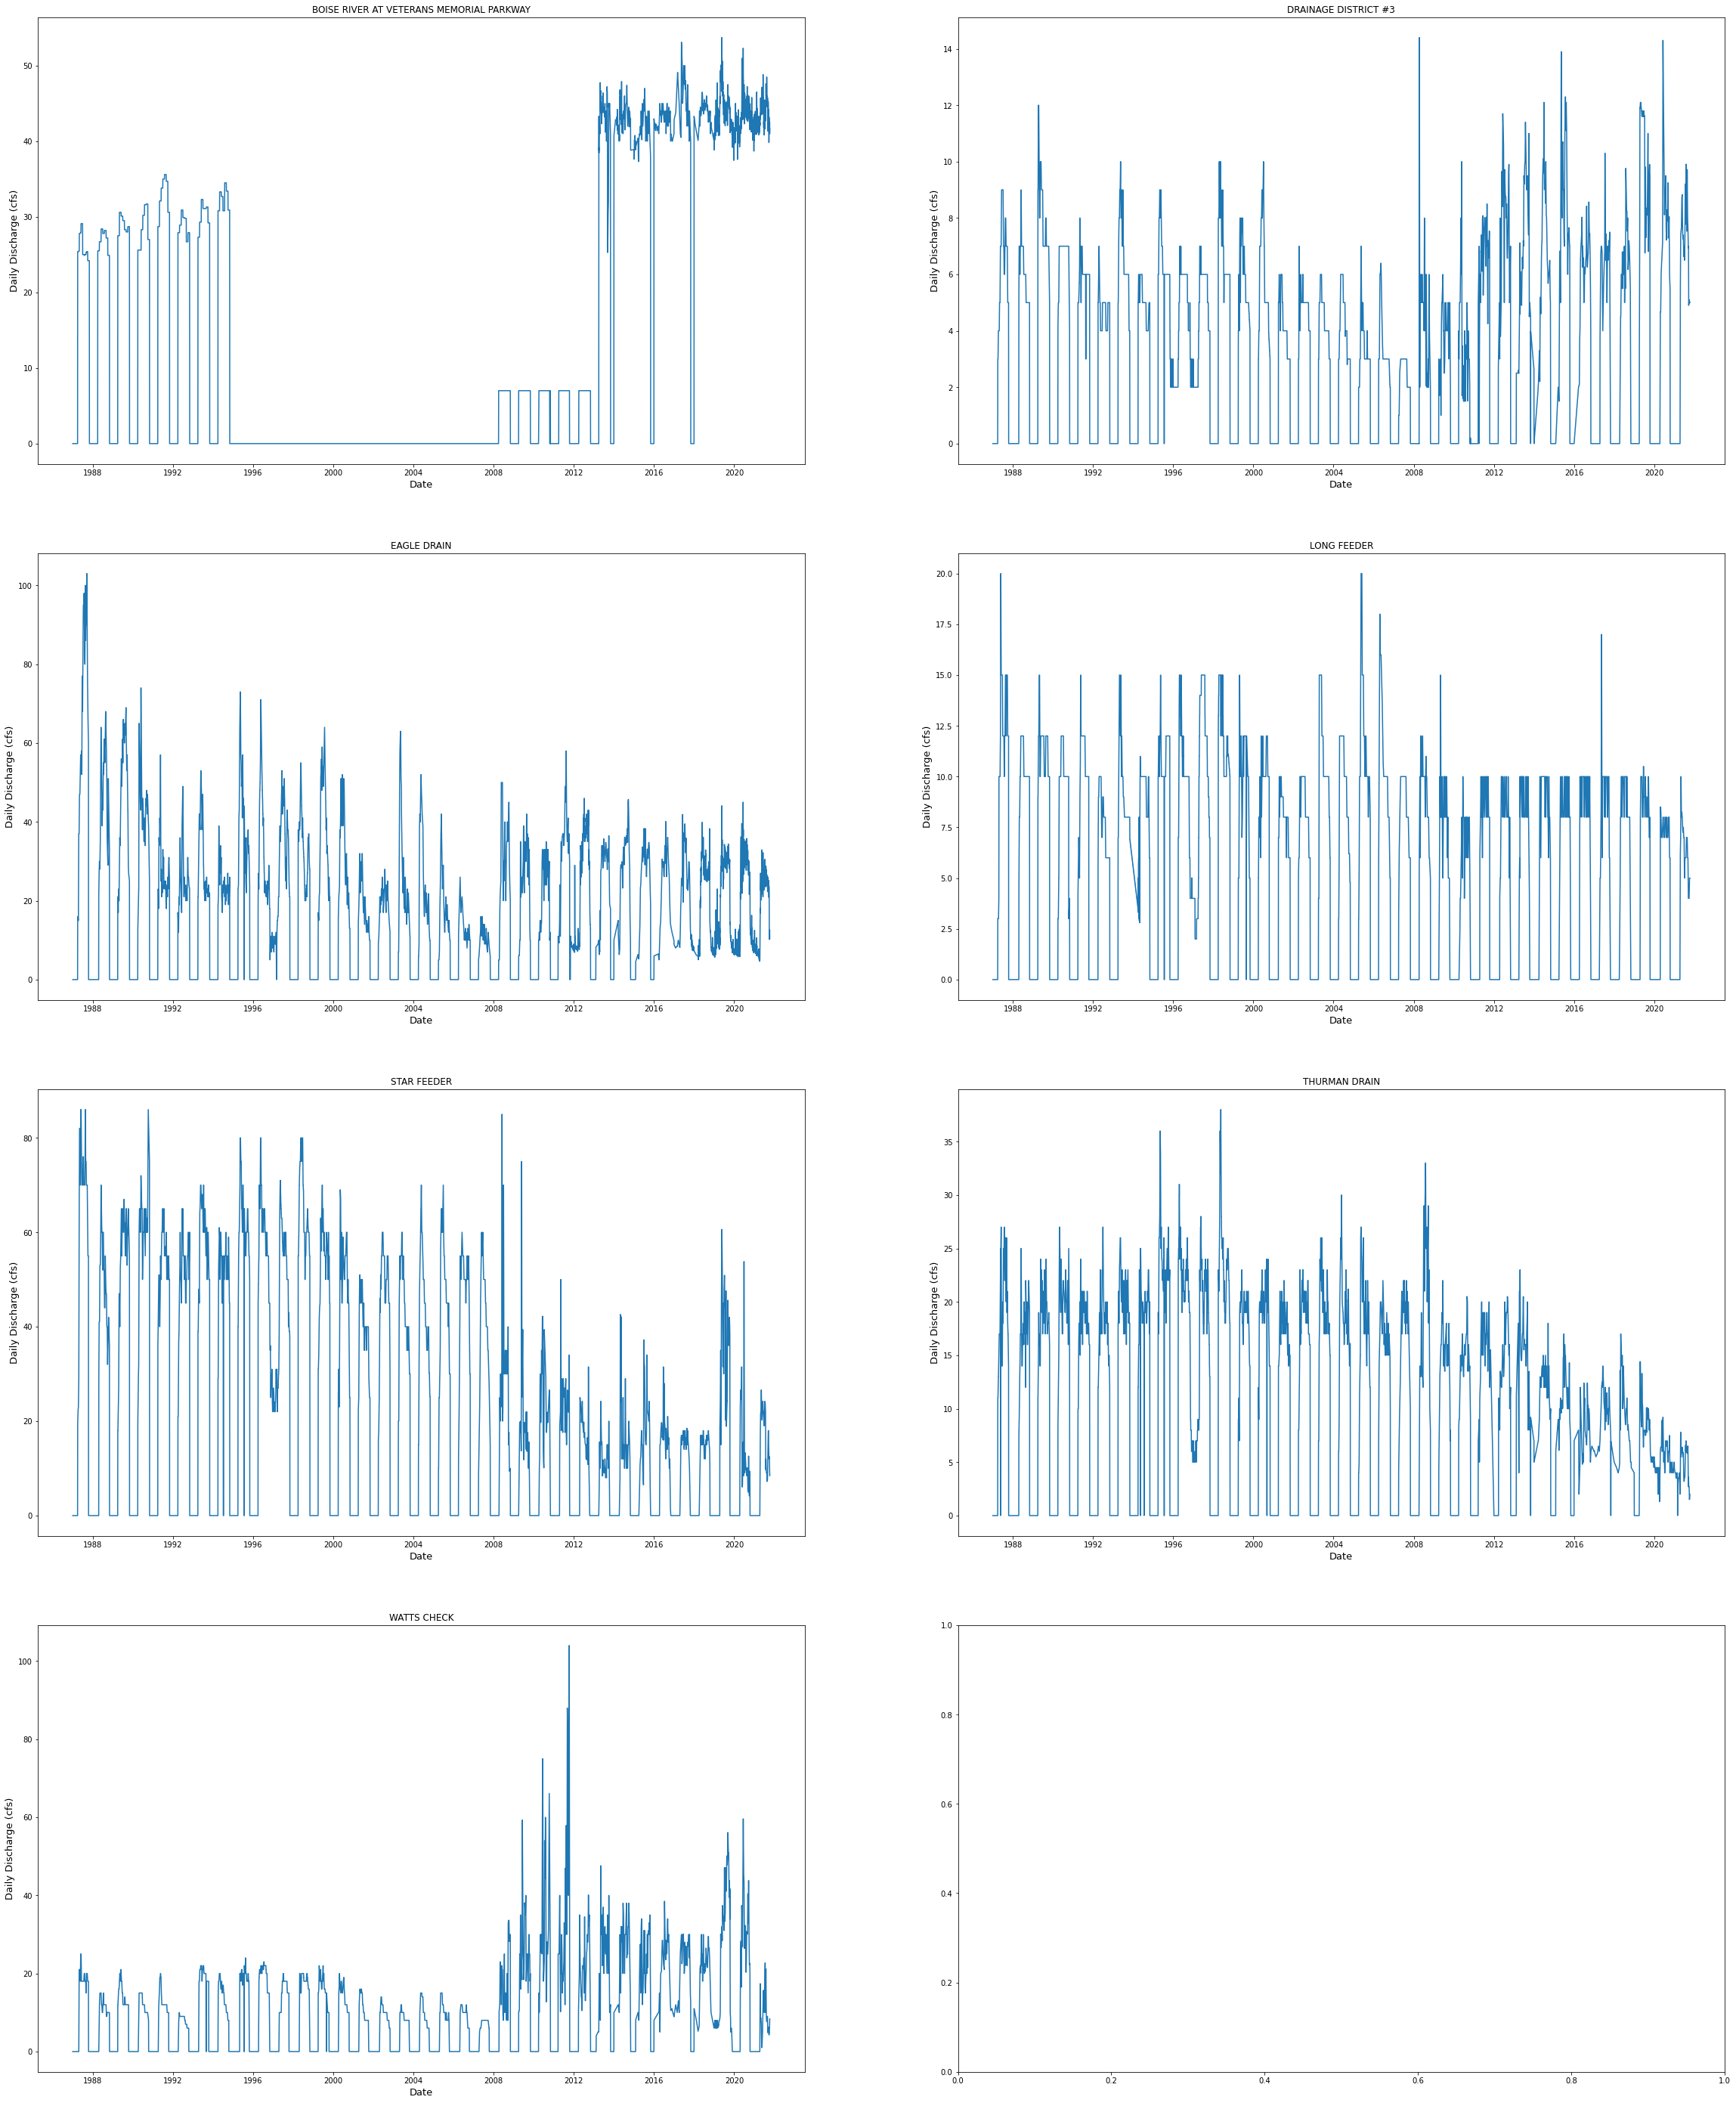

In [10]:
## PLOT THE RAW DATA TO VISUALLY ANALYZE TRENDS AND SEASONALITY

i,j = 0,0
plot_row = 2 #number of plots per row in figure
figure, ax = plt.subplots(4, plot_row, figsize=(40,50)) #create the figure

for n in range(len(drains)): #run a for loop to add all plots to figure
  canal_data = drains[n] #takes an individual diversion point dataframe
  ax[i][j].plot(canal_data.index, canal_data['CFS'])
  ax[i][j].set_ylabel('Daily Discharge (cfs)', size=13)
  ax[i][j].set_xlabel('Date', size=13)
  ax[i][j].title.set_text(names[n])
  j+=1
  if j%plot_row==0:
    i+=1
    j=0
plt.savefig('datasets/diversion_timeseries/drain_figs/rawdata.png')


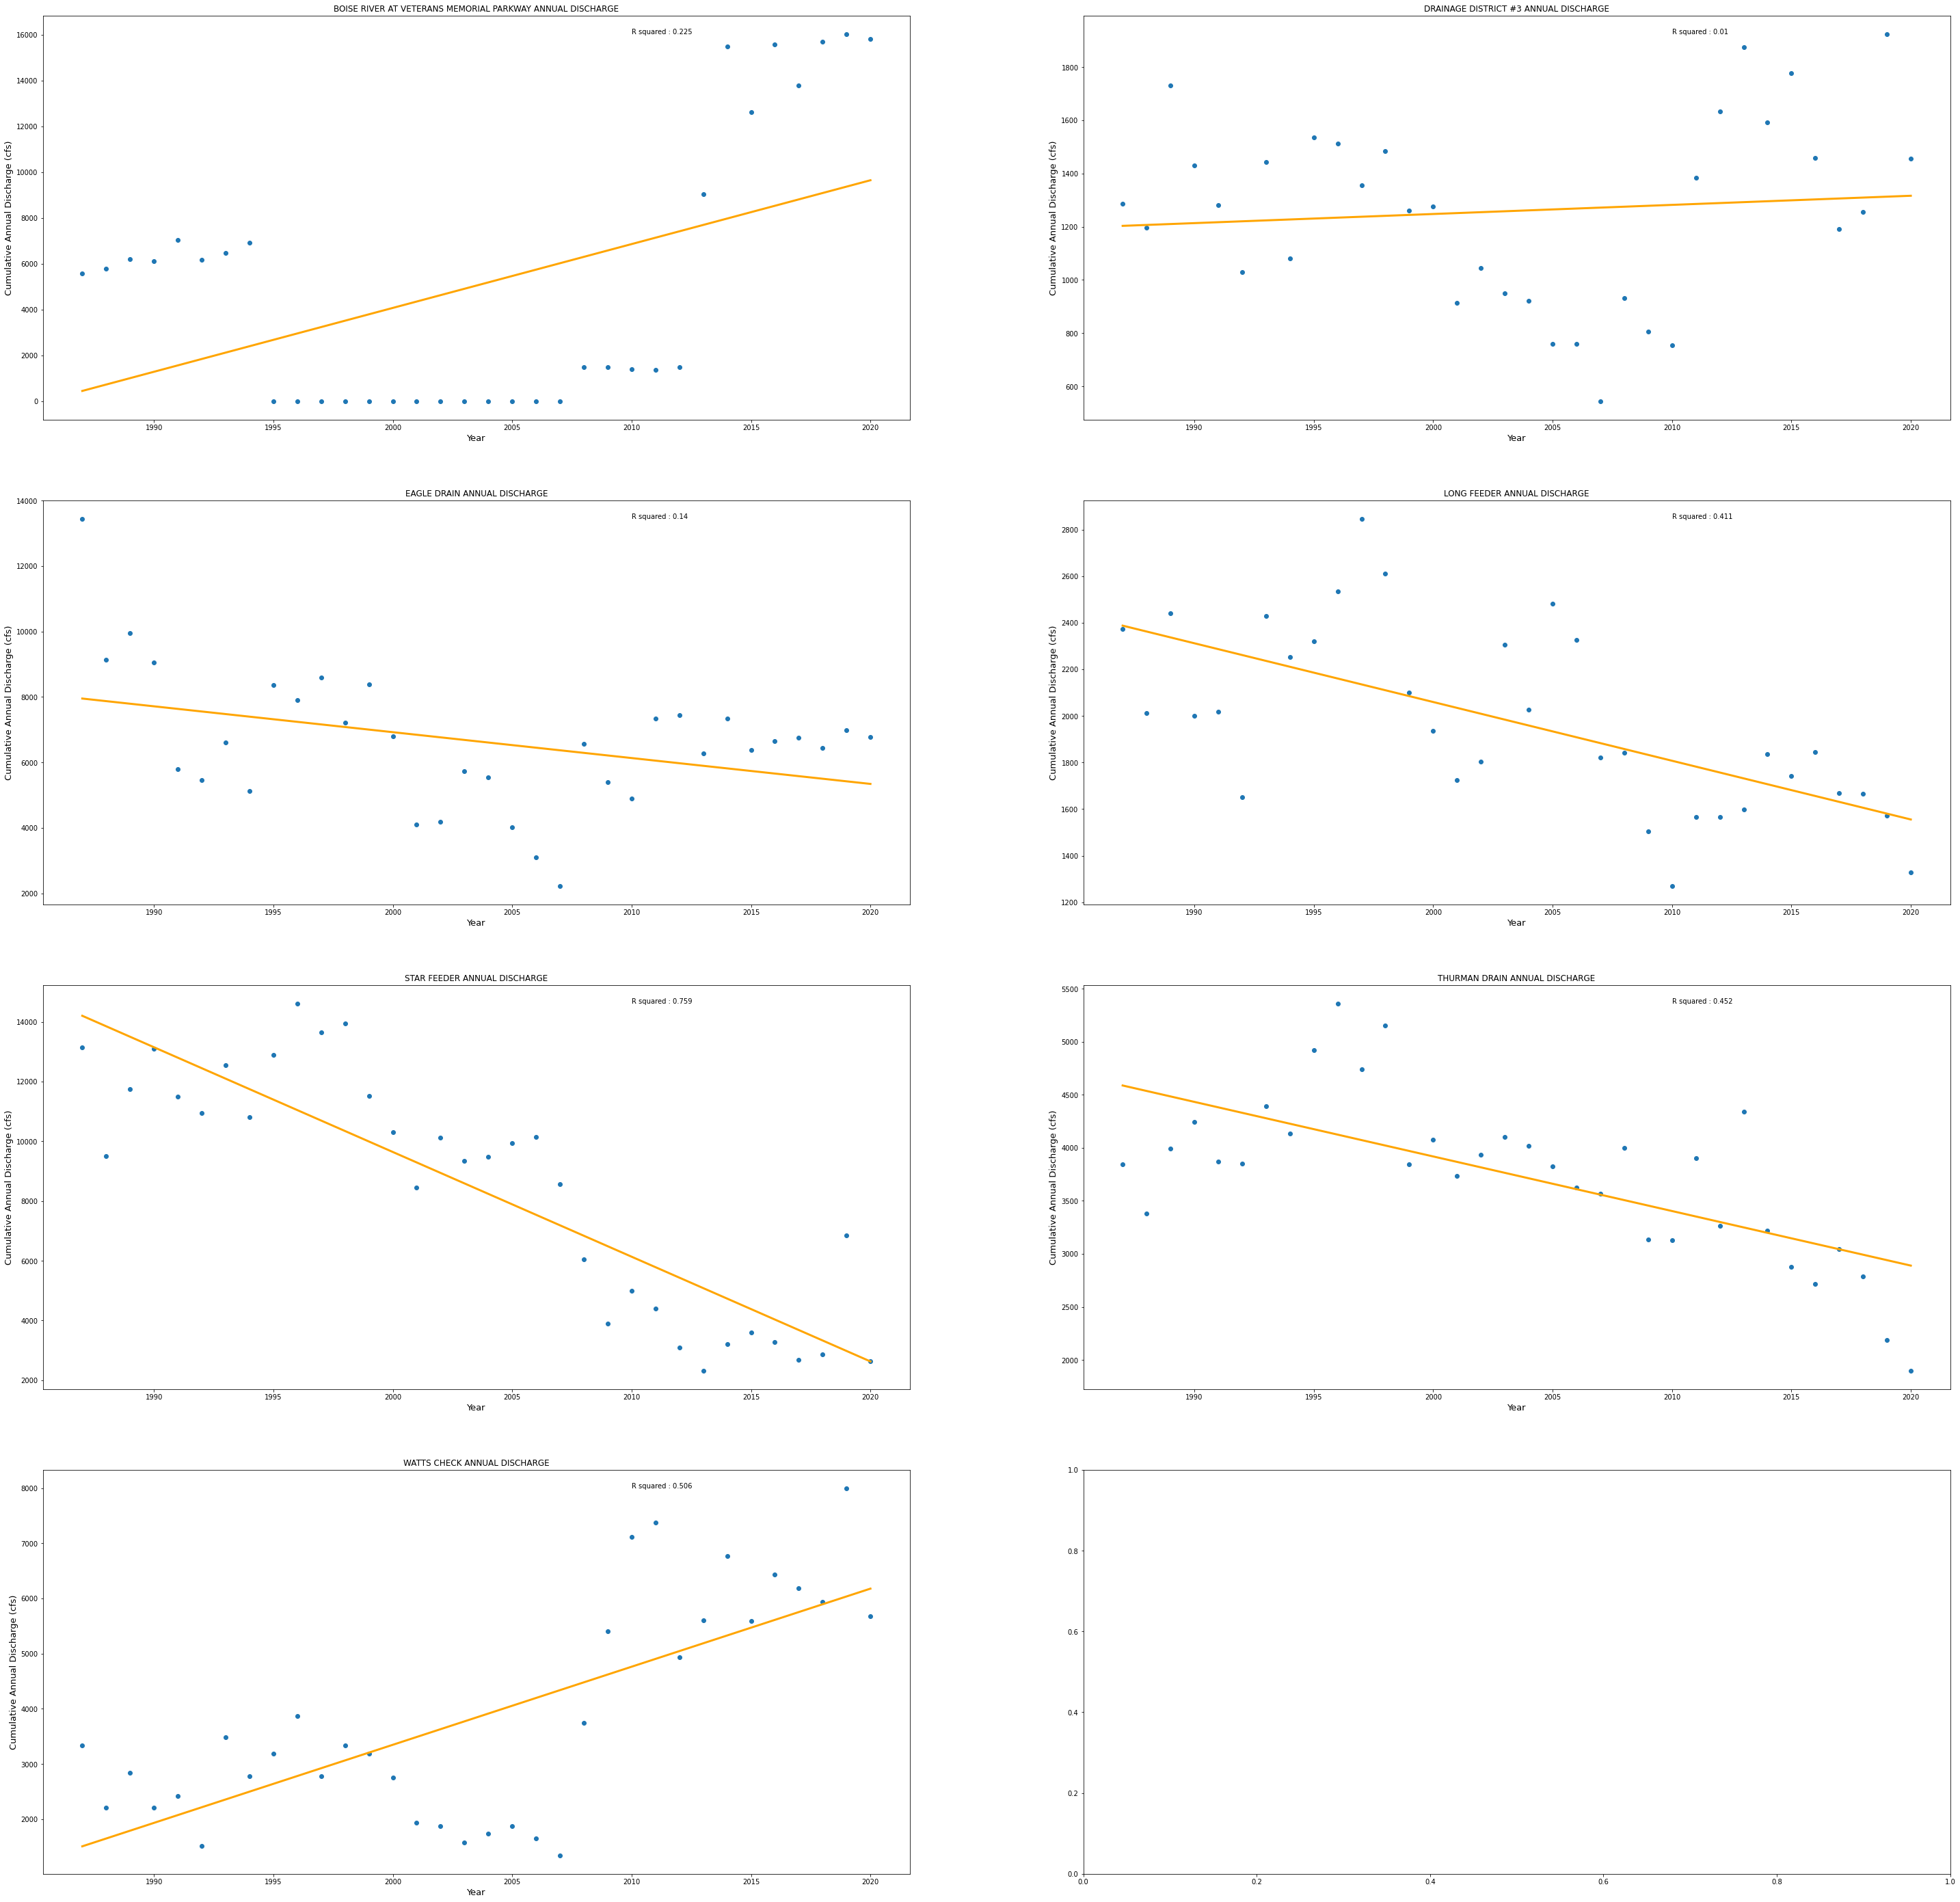

In [13]:
### FIND THE TOTAL WATER DIVERTED ANNUALLY ###

years = np.arange(1987, 2021, 1)
totals = np.empty((len(years), len(drains)))
totals_df = []

for i in range(len(drains)):
  tot_list = []
  for y in range(len(years)):
    sub_canal = drains[i]
    Ix = sub_canal.index.year == years[y] #index the year
    subset_year = sub_canal[Ix] #subset the data to the specified year
    totals[y][i] = sum(subset_year['CFS']) #sum the total discharge throughout the year
    tot_list.append([years[y], sub_canal['DiversionName'][0], sum(subset_year['CFS'])])
  tot_todf = pd.DataFrame(tot_list, columns = ['Year', 'Diversion Name', 'Total'])
  totals_df.append(tot_todf)

## CALCULATE THE REGRESSION ##

regression = np.empty((len(years), len(drains)))
rsquared = np.empty(len(drains))

for i  in range(len(drains)):
  model = np.polyfit(years, totals[:,i], deg=1) #runs regression for coefficients
  regression[:,i] = np.polyval(model, years) #uses x to predict model values
  rsquared[i] = metrics.r2_score(totals[:,i], regression[:,i]) #compares correlation of model to true values


## CREATE SUBPLOTS FOR THE CHART ##

i,j = 0,0
plot_row = 2 #number of plots per row in figure
figure, ax = plt.subplots(4, plot_row, figsize=(50,50)) #create the figure

for n in range(len(drains)): #run a for loop to add all plots to figure
  canal = drains[n]
  canal_data = totals[:,n] #takes an individual diversion point datafram
  ax[i][j].plot(years, canal_data, 'o')
  ax[i][j].plot(years, regression[:,n], color = 'orange', linewidth=3)
  ax[i][j].set_ylabel('Cumulative Annual Discharge (cfs)', size=13)
  ax[i][j].set_xlabel('Year', size=13)
  ax[i][j].title.set_text(canal['DiversionName'][0]+' ANNUAL DISCHARGE')
  text = 'R squared : '+str(np.around(rsquared[n], 3))
  ax[i][j].text(2010, np.max(totals[:,n]), s=text)
  j+=1
  if j%plot_row==0:
    i+=1
    j=0
plt.savefig('datasets/diversion_timeseries/drain_figs/totals.png')

In [14]:
## CALCULATE BASIC VOLUME STATISTICS ##

stats = []

for i in range(len(drains)):
  canal = drains[i]
  avg = np.mean(canal['CFS'][canal['CFS'] != 0])
  std_dev = np.std(canal['CFS'][canal['CFS'] != 0])
  avg_withzero = np.mean(canal['CFS'])
  std_withzero = np.std(canal['CFS'])
  coeff_var = std_dev/avg
  coeff_var_withzero = std_withzero/avg_withzero
  maximum = np.max(canal['CFS'])
  minimum = np.min(canal['CFS'][canal['CFS'] != 0])
  stats.append([canal['DiversionName'][0], avg, std_dev, coeff_var, maximum, minimum, avg_withzero, std_withzero, coeff_var_withzero])

base_stats = pd.DataFrame(stats, columns = ['DiversionName', 'Mean', 'Standard_dev', 
                                            'Coefficient_Variation', 'Maximum', 'Minimum', 
                                            'Mean_ZeroValues', 'Standard_dev_ZeroValues',
                                            'Coefficient_ZeroValues'])


display(base_stats)
base_stats.to_csv('datasets/diversion_timeseries/drain_figs/stats.csv')



,DiversionName,Mean,Standard_dev,Coefficient_Variation,Maximum,Minimum,Mean_ZeroValues,Standard_dev_ZeroValues,Coefficient_ZeroValues
0,BOISE RIVER AT VETERANS MEMORIAL PARKWAY,32.350308,13.639601,0.421622,53.72,1.17,14.480347,18.494220,1.277195
1,DRAINAGE DISTRICT #3,5.554769,2.320308,0.417714,14.40,0.01,3.475065,3.255032,0.936682
2,EAGLE DRAIN,26.323492,15.538182,0.590278,103.00,1.00,18.192076,17.742106,0.975266
3,LONG FEEDER,9.097280,2.813828,0.309304,20.00,0.14,5.368276,4.968952,0.925614
4,STAR FEEDER,39.496897,19.947352,0.505036,86.00,0.25,22.769092,24.703354,1.084951
5,THURMAN DRAIN,14.825196,6.469875,0.436411,38.00,0.25,10.105595,8.730851,0.863962
6,WATTS CHECK,17.529211,10.332530,0.589446,104.00,0.56,10.421208,11.727918,1.125390


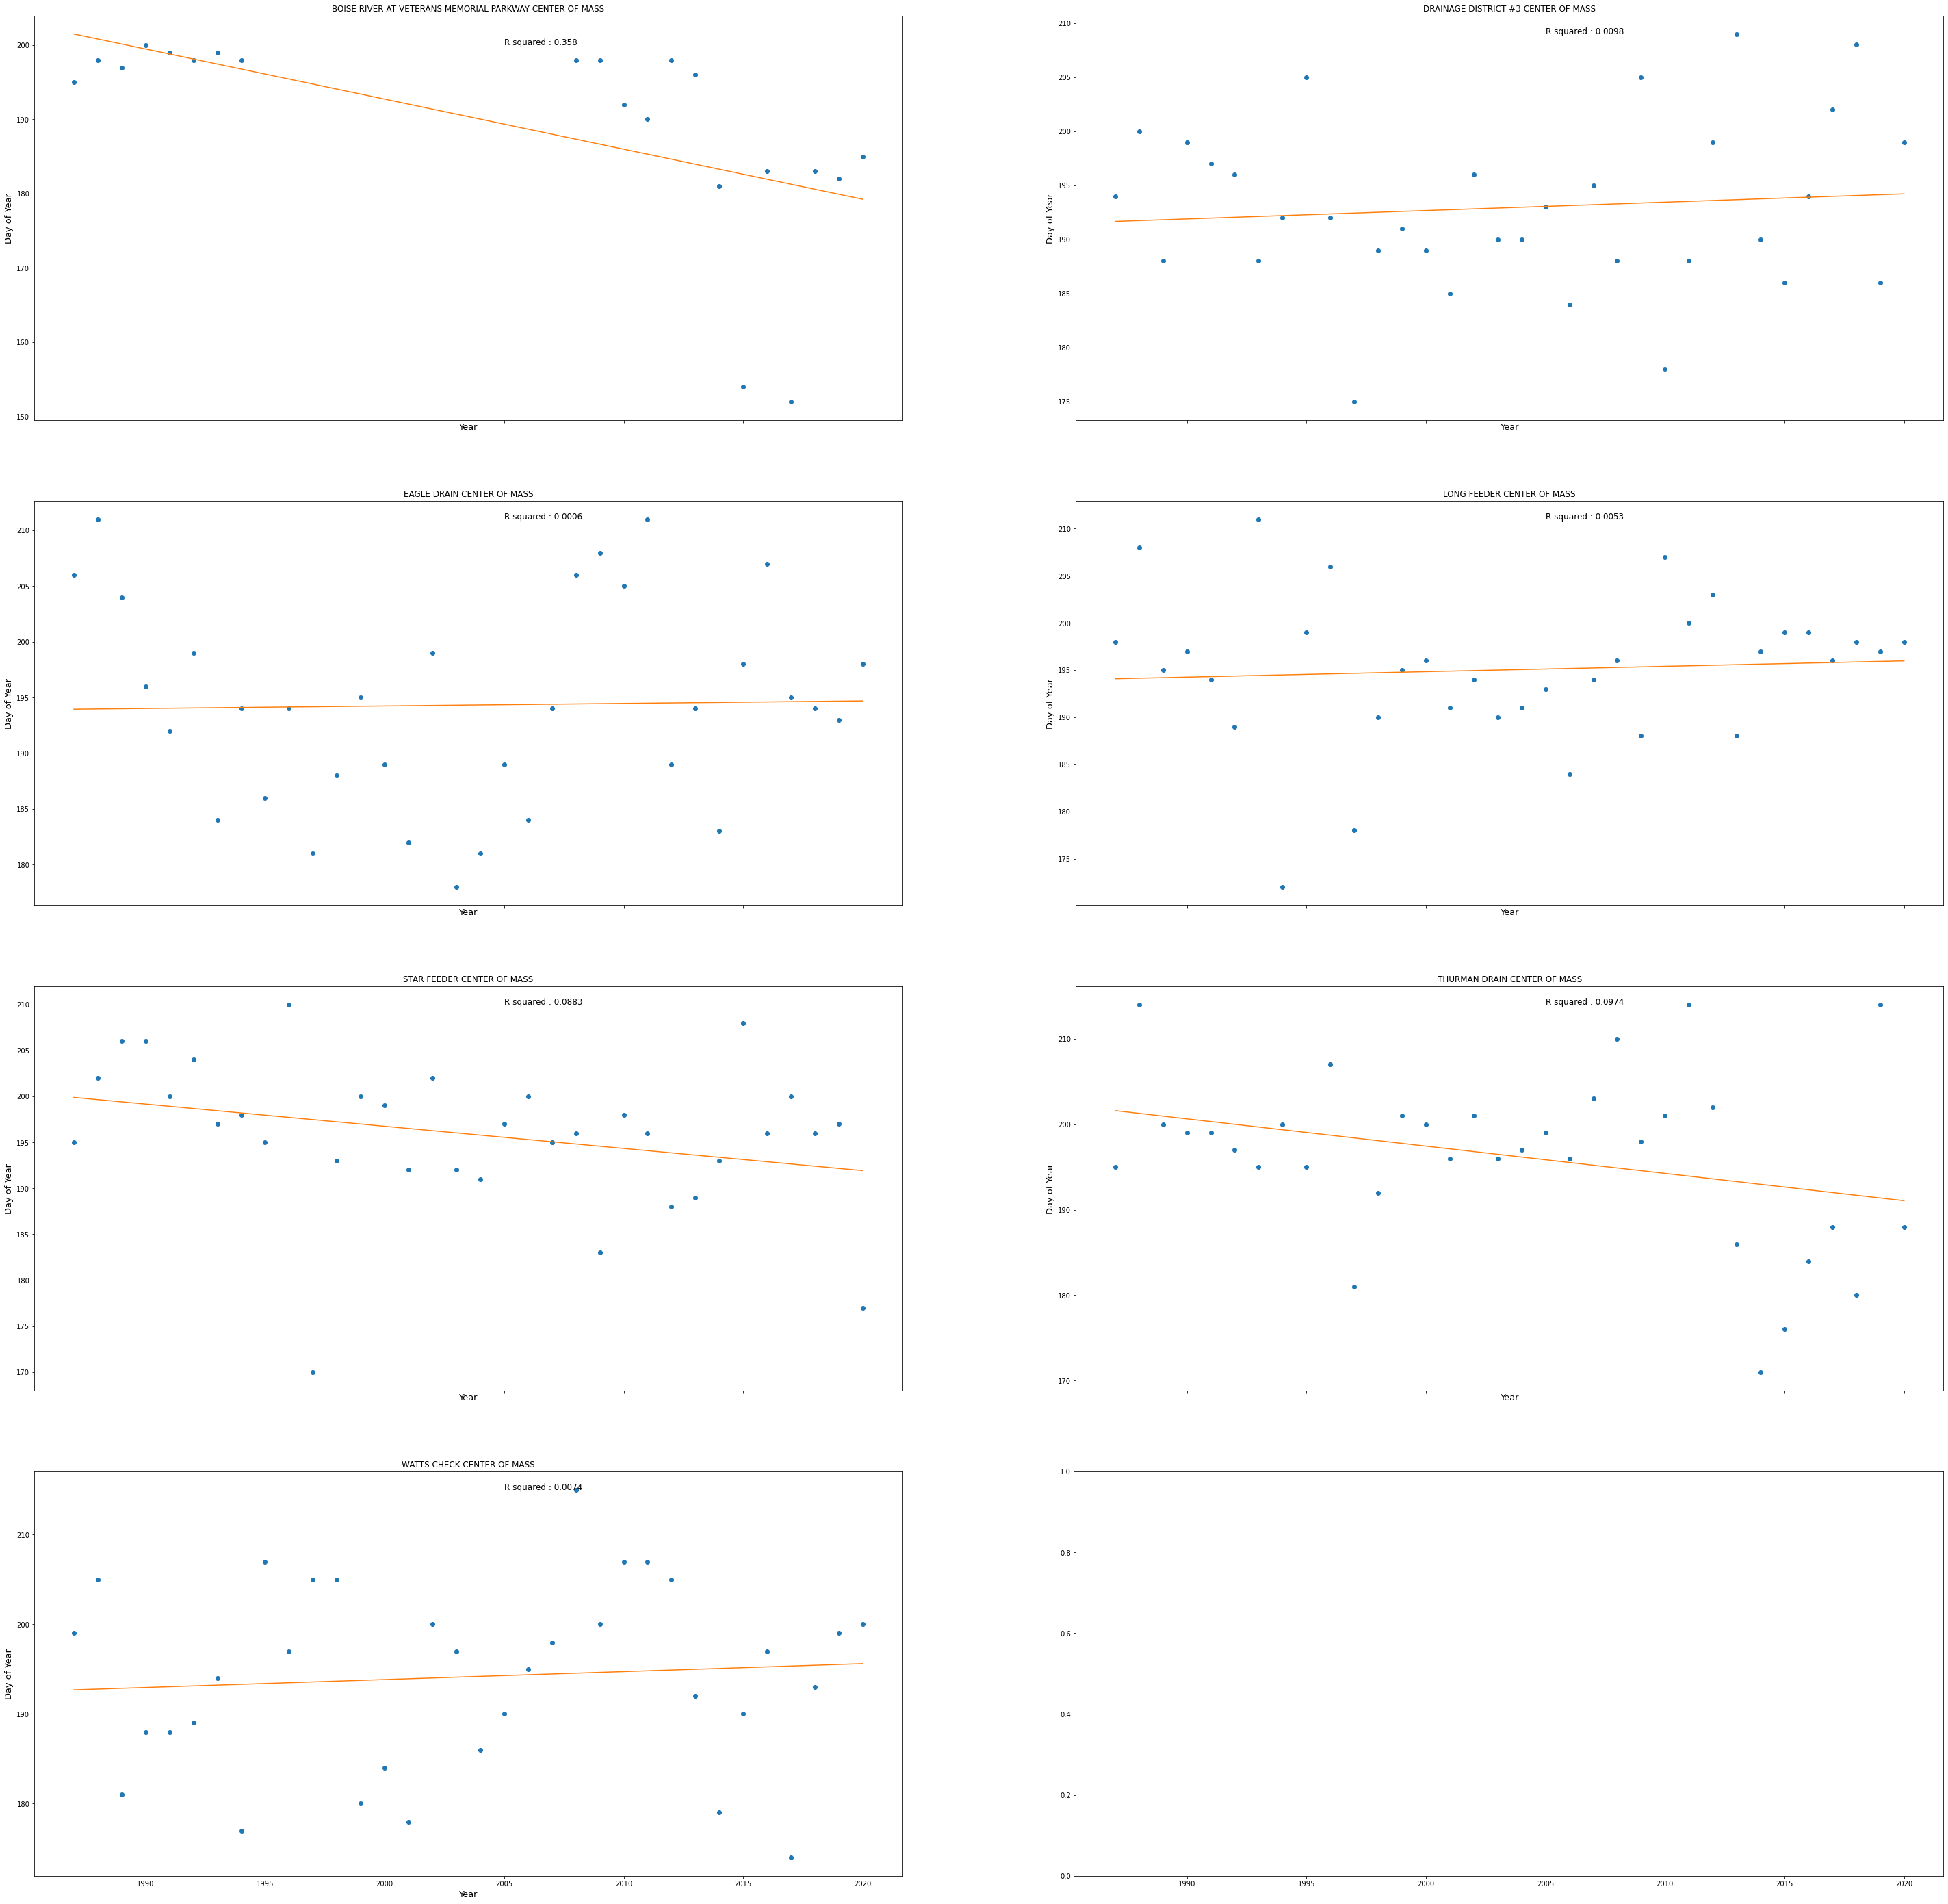

In [17]:
## FIND THE CENTER OF MASS OF THE IRRIGATION SEASON ##

centroid_df = []

for n in range(len(drains)):
  cent_list = []
  for i in range(len(years)):
    canal = drains[n]
    tots = totals_df[n]
    year = canal[canal.index.year == years[i]]
    tot_year = int(tots['Total'][tots['Year'] == years[i]])
    if tot_year == 0:
      None
    else:
      cent = round(np.sum(year.index.dayofyear*year['CFS'])/np.sum(year['CFS']))
      cent_list.append([years[i], canal['DiversionName'][0], cent])
  cent_todf = pd.DataFrame(cent_list, columns = ['Year', 'DiversionName', 'CentroidDay'])
  centroid_df.append(cent_todf)

## Check to see if there is a trend in the data through time

r_squared_df = []

for i in range(len(drains)):
  canal = centroid_df[i]
  model = np.polyfit(canal['Year'], canal['CentroidDay'], deg=1)
  canal['Model'] = np.polyval(model, canal['Year'])
  centroid_df[i] = canal
  r_squared = metrics.r2_score(canal['CentroidDay'], canal['Model'])
  r_squared_df.append([canal['DiversionName'][0], r_squared])

r_squared_df = pd.DataFrame(r_squared_df, columns =['DiversionName', 'RSquared'])

## PLOT THE DAY AT CENTER OF MASS FOR EACH CANAL ##

i,j = 0,0
plot_row = 2 #number of plots per row in figure
figure, ax = plt.subplots(4, plot_row, figsize=(50,50), sharex=True) #create the figure

for n in range(len(drains)): #run a for loop to add all plots to figure
  canal_data = centroid_df[n] #takes an individual diversion point dataframe
  r_squared = r_squared_df['RSquared'][n]
  ax[i][j].plot(canal_data['Year'], canal_data['CentroidDay'], 'o')
  ax[i][j].plot(canal_data['Year'], canal_data['Model'])
  ax[i][j].set_ylabel('Day of Year', size=13)
  ax[i][j].set_xlabel('Year', size=13)
  ax[i][j].title.set_text(canal_data['DiversionName'][0] +' CENTER OF MASS')
  ax[i][j].tick_params('both')
  ax[i][j].text(2005, np.max(canal_data['CentroidDay']), s='R squared : ' + str(np.around(r_squared, 4)), size=12)
  j+=1
  if j%plot_row==0:
    i+=1
    j=0
plt.savefig('datasets/diversion_timeseries/drain_figs/centroid_time.png')

In [19]:
## FIND OTHER IRRIGATION SEASON TIMING METRICS ##

## Create a dataframe housing info:                 ##
## ------------------------------------------------ ##
## Column 1: Name of diversion                      ##
## Column 2: Date start of Irrigation season        ##
## Column 3: Day of year start of Irrigation season ##
## Column 4: Date end of irrigation season          ##
## Column 5: Date of year end of Irrigation season  ##
## Column 6: Length of Irrigation Season            ##
## ------------------------------------------------ ##

season_df = []

## Add a column to original canals dataframe to get the daily cumulative sum of 
#  discharge each year during the irrigation season (used for start and end days)
for i in range(len(drains)):
  for j in range(len(years)):
    sub_canal = drains[i]
    drains[i]['Sum'] = sub_canal.groupby(sub_canal.index.year)['CFS'].cumsum()

for i in range(len(drains)):
  length = []
  for y in range(len(years)):
    canal_data = drains[i]
    canal_name = canal_data['DiversionName'][1]
    canal_by_year = canal_data[canal_data.index.year == years[y]]
    if np.min(canal_by_year['Sum']) == 0:
      min_Ix = np.where(canal_by_year['Sum'] == np.min(canal_by_year['Sum']))
      min_Ix = min_Ix[0]
      min_Ix = min_Ix[-1]
      start_date = canal_by_year.index[min_Ix]
      start_dayofyear = canal_by_year.index.dayofyear[min_Ix]
    else:
      start_date = 'NaN'
      start_dayofyear = 1
    max_Ix = np.where(canal_by_year['Sum'] == np.max(canal_by_year['Sum']))
    max_Ix= max_Ix[0]
    max_Ix = max_Ix[0]
    end_date = canal_by_year.index[max_Ix]
    end_dayofyear = canal_by_year.index.dayofyear[max_Ix]
    irrig_season_range = end_dayofyear-start_dayofyear
    length.append([canal_name, start_date, start_dayofyear, end_date, end_dayofyear, irrig_season_range])
  length_df = pd.DataFrame(length, columns = ['DiversionName', 'StartDate', 'StartDayofYear',
                                            'EndDate', 'EndDayofYear', 'Range'])
  season_df.append(length_df)


In [20]:
## BASIC STATISTICS ON TIMING ##

time_stats = []

for i in range(len(drains)):
  cent = centroid_df[i]
  canal_timing = season_df[i]
  avg_start = np.mean(canal_timing['StartDayofYear'])
  std_start = np.std(canal_timing['StartDayofYear'])
  avg_end = np.mean(canal_timing['EndDayofYear'])
  std_end = np.std(canal_timing['EndDayofYear'])
  avg_length = np.mean(canal_timing['Range'])
  std_length = np.std(canal_timing['Range'])
  avg_centroid = np.mean(cent['CentroidDay'])
  std_centroid = np.std(cent['CentroidDay'])
  time_stats.append([cent['DiversionName'][0], avg_start, std_start, avg_end, std_end, avg_length, 
                     std_length, avg_centroid, std_centroid])
  
time_stats = pd.DataFrame(time_stats, columns = ['DivName', 'avg_start', 'std_start', 
                                                 'avg_end','std_end', 'avg_length', 
                                                 'std_length','avg_centroid', 'std_centroid'])

time_stats.to_csv('datasets/diversion_timeseries/drain_figs/time_stats.csv')
display(time_stats)

,DivName,avg_start,std_start,avg_end,std_end,avg_length,std_length,avg_centroid,std_centroid
0,BOISE RIVER AT VETERANS MEMORIAL PARKWAY,177.029412,151.726434,196.794118,155.477969,19.764706,306.455165,189.333333,13.378495
1,DRAINAGE DISTRICT #3,77.882353,31.426632,306.941176,19.055555,229.058824,41.631395,192.941176,7.677090
2,EAGLE DRAIN,66.058824,38.641597,316.323529,25.155657,250.264706,56.370262,194.323529,9.034967
3,LONG FEEDER,88.500000,22.775438,303.823529,16.756861,215.323529,29.135304,195.029412,7.728805
4,STAR FEEDER,91.558824,16.969161,302.000000,12.929674,210.441176,22.626366,195.911765,7.964508
5,THURMAN DRAIN,71.558824,35.278882,318.117647,26.291091,246.558824,53.868681,196.323529,10.034413
6,WATTS CHECK,82.647059,38.246017,299.735294,19.054579,217.088235,53.514356,194.147059,10.096978


In [32]:
## Test if time series is stationary ##
## Mann_Kendall Test : A nonparametric test often used to detect changes in streamflow


# Test if volume time series is stationary
outs = []

for i in range(len(drains)):
  canal = drains[i]
  input = np.array(canal['CFS'])
  test = mk.seasonal_test(input, period=365, alpha=0.05)
  trend, hyp, pval, slope, intercept = [test.trend, test.h, test.p, test.slope, test.intercept]
  outs.append([canal['DiversionName'][0], trend, hyp, pval, slope, intercept])

mannkend_out = pd.DataFrame(outs, columns = ['Name', 'Trend', 'Hypothesis', 'Pvalue', 'Slope', 'Intercept'])
display(mannkend_out)

# Test to see if annual time series is stationary 

annual_outs = []

for i in range(len(drains)):
  drain = drains[i]
  annual = totals[:,i]
  test = mk.original_test(annual, alpha = 0.05)
  trend, hyp, pval, slope, intercept = [test.trend, test.h, test.p, test.slope, test.intercept]
  annual_outs.append([drain['DiversionName'][0], trend, hyp, pval, slope, intercept])
  
mannkend_annual = pd.DataFrame(annual_outs, columns = ['Name', 'Trend', 'Hypothesis', 'Pvalue', 'Slope', 'Intercept'])
display(mannkend_annual)

# Test if length of irrigation season time series is stationary

length_outs = []

for i in range(len(drains)):
  canal = season_df[i]
  input = np.array(canal['Range'])
  test = mk.original_test(input, alpha=0.05)
  trend, hyp, pval, slope, intercept = [test.trend, test.h, test.p, test.slope, test.intercept]
  length_outs.append([canal['DiversionName'][0], trend, hyp, pval, slope, intercept])

mannkend_length = pd.DataFrame(length_outs, columns = ['Name', 'Trend', 'Hypothesis', 'Pvalue', 'Slope', 'Intercept'])
display(mannkend_length)

# Test if centroid time series is stationary

centroid_outs = []

for i in range(len(drains)):
  canal = centroid_df[i]
  input = np.array(canal['CentroidDay'])
  test = mk.original_test(input, alpha=0.05)
  trend, hyp, pval, slope, intercept = [test.trend, test.h, test.p, test.slope, test.intercept]
  centroid_outs.append([canal['DiversionName'][0], trend, hyp, pval, slope, intercept])

mannkend_centroid = pd.DataFrame(centroid_outs, columns = ['Name', 'Trend', 'Hypothesis', 'Pvalue', 'Slope', 'Intercept'])
display(mannkend_centroid)




,Name,Trend,Hypothesis,Pvalue,Slope,Intercept
0,BOISE RIVER AT VETERANS MEMORIAL PARKWAY,increasing,True,0.000000,0.0,0.0
1,DRAINAGE DISTRICT #3,no trend,False,0.687069,0.0,3.2
2,EAGLE DRAIN,no trend,False,0.206545,0.0,14.9
3,LONG FEEDER,decreasing,True,0.000000,0.0,6.1
4,STAR FEEDER,decreasing,True,0.000000,0.0,15.0
5,THURMAN DRAIN,decreasing,True,0.000000,0.0,9.5
6,WATTS CHECK,increasing,True,0.000000,0.0,8.5


,Name,Trend,Hypothesis,Pvalue,Slope,Intercept
0,BOISE RIVER AT VETERANS MEMORIAL PARKWAY,increasing,True,1.269867e-02,130.812000,-660.398000
1,DRAINAGE DISTRICT #3,no trend,False,1.000000e+00,-0.184138,1281.538276
2,EAGLE DRAIN,no trend,False,9.684655e-02,-69.673226,7785.168226
3,LONG FEEDER,decreasing,True,3.338442e-04,-24.563636,2296.560000
4,STAR FEEDER,decreasing,True,1.768054e-08,-343.080952,15153.385714
5,THURMAN DRAIN,decreasing,True,3.312513e-05,-52.750000,4717.375000
6,WATTS CHECK,increasing,True,2.615121e-03,128.211304,1146.013478


,Name,Trend,Hypothesis,Pvalue,Slope,Intercept
0,BOISE RIVER AT VETERANS MEMORIAL PARKWAY,increasing,True,7.621589e-03,1.000000,197.500000
1,DRAINAGE DISTRICT #3,no trend,False,9.746490e-01,0.000000,214.000000
2,EAGLE DRAIN,increasing,True,8.250337e-07,2.571429,171.571429
3,LONG FEEDER,decreasing,True,4.416754e-03,-0.357143,219.392857
4,STAR FEEDER,decreasing,True,2.133902e-04,-0.533333,222.800000
5,THURMAN DRAIN,increasing,True,9.318557e-06,1.285714,192.785714
6,WATTS CHECK,increasing,True,5.784117e-04,2.000000,161.500000


,Name,Trend,Hypothesis,Pvalue,Slope,Intercept
0,BOISE RIVER AT VETERANS MEMORIAL PARKWAY,decreasing,True,0.000756,-1.000000,206.000000
1,DRAINAGE DISTRICT #3,no trend,False,1.000000,0.000000,192.000000
2,EAGLE DRAIN,no trend,False,0.928911,0.000000,194.000000
3,LONG FEEDER,no trend,False,0.542326,0.071429,194.821429
4,STAR FEEDER,decreasing,True,0.041590,-0.250000,200.625000
5,THURMAN DRAIN,no trend,False,0.312145,-0.235294,201.382353
6,WATTS CHECK,no trend,False,0.475628,0.125000,193.937500


In [45]:

base_stats['Trend'] = mannkend_annual['Trend']
base_stats['Change'] = mannkend_annual['Intercept']-(mannkend_annual['Intercept']+mannkend_annual['Slope']*34)

display(base_stats)

,DiversionName,Mean,Standard_dev,Coefficient_Variation,Maximum,Minimum,Mean_ZeroValues,Standard_dev_ZeroValues,Coefficient_ZeroValues,Change,Trend
0,BOISE RIVER AT VETERANS MEMORIAL PARKWAY,32.350308,13.639601,0.421622,53.72,1.17,14.480347,18.494220,1.277195,-4447.608000,increasing
1,DRAINAGE DISTRICT #3,5.554769,2.320308,0.417714,14.40,0.01,3.475065,3.255032,0.936682,6.260690,no trend
2,EAGLE DRAIN,26.323492,15.538182,0.590278,103.00,1.00,18.192076,17.742106,0.975266,2368.889677,no trend
3,LONG FEEDER,9.097280,2.813828,0.309304,20.00,0.14,5.368276,4.968952,0.925614,835.163636,decreasing
4,STAR FEEDER,39.496897,19.947352,0.505036,86.00,0.25,22.769092,24.703354,1.084951,11664.752381,decreasing
5,THURMAN DRAIN,14.825196,6.469875,0.436411,38.00,0.25,10.105595,8.730851,0.863962,1793.500000,decreasing
6,WATTS CHECK,17.529211,10.332530,0.589446,104.00,0.56,10.421208,11.727918,1.125390,-4359.184348,increasing
